# Sound localisation following Dale' law

Work in progress.

In this notebook, we explore how surrogate gradient descent solves the sound localisation problem when restricted to using only excitatory or inhibitory connections.

We use the spiking solution provided in the last section of the Starting Network and we force W1 (input to hidden layer) and W2 (hidden to output layer) to be positive. We reason that this might constrain the learning to a more classical coincidence-detector strategy on the hidden layer. It is also more biologically relevant since neurons often have an excitatory or inhibitory effect on their partners but not both (known as Dale's law).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm

import torch
import torch.nn as nn

from tqdm.auto import tqdm as pbar

dtype = torch.float

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [2]:
# Constants
SECONDS = 1
MS = 1e-3
HZ = 1

DT = 1 * MS            # large time step to make simulations run faster
ANF_PER_EAR = 100    # repeats of each ear with independent noise

DURATION = .1 * SECONDS # stimulus duration
DURATION_STEPS = int(np.round(DURATION / DT))
INPUT_SIZE = 2 * ANF_PER_EAR

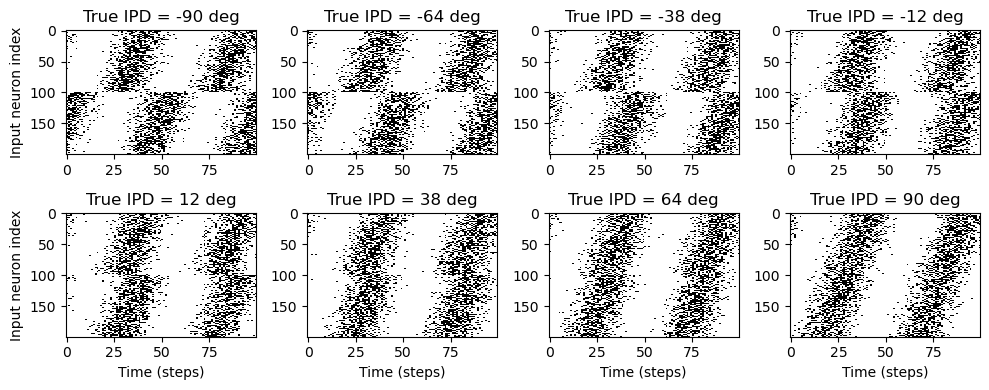

In [3]:
def input_signal(ipd):
    """
    Generate an input signal (spike array) from array of true IPDs
    """
    envelope_power = 2   # higher values make sharper envelopes, easier
    rate_max = 600 * HZ   # maximum Poisson firing rate
    stimulus_frequency = 20 * HZ

    num_samples = len(ipd)
    times = np.arange(DURATION_STEPS) * DT # array of times
    phi = 2*np.pi*(stimulus_frequency * times + np.random.rand()) # array of phases corresponding to those times with random offset
    # each point in the array will have a different phase based on which ear it is
    # and its delay
    theta = np.zeros((num_samples, DURATION_STEPS, 2*ANF_PER_EAR))
    # for each ear, we have anf_per_ear different phase delays from to pi/2 so
    # that the differences between the two ears can cover the full range from -pi/2 to pi/2
    phase_delays = np.linspace(0, np.pi/2, ANF_PER_EAR)
    # now we set up these theta to implement that. Some numpy vectorisation logic here which looks a little weird,
    # but implements the idea in the text above.
    theta[:, :, :ANF_PER_EAR] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]
    theta[:, :, ANF_PER_EAR:] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]+ipd[:, np.newaxis, np.newaxis]
    # now generate Poisson spikes at the given firing rate as in the previous notebook
    spikes = np.random.rand(num_samples, DURATION_STEPS, 2*ANF_PER_EAR)<rate_max*DT*(0.5*(1+np.sin(theta)))**envelope_power
    return spikes

def random_ipd_input_signal(num_samples, tensor=True):
    """
    Generate the training data
    Returns true IPDs from U(-pi/2, pi/2) and corresponding spike arrays
    """
    ipd = np.random.rand(num_samples)*np.pi-np.pi/2 # uniformly random in (-pi/2, pi/2)
    spikes = spikes_from_fixed_idp_input_signal(ipd, tensor)

    if tensor:
        ipd = torch.tensor(ipd, device=device, dtype=dtype)        

    return ipd, spikes

def spikes_from_fixed_idp_input_signal(ipd, tensor=True):
    spikes = input_signal(ipd)
    if tensor:
        spikes = torch.tensor(spikes, device=device, dtype=dtype)
    return spikes

def show_examples(shown=8):
    ipd = np.linspace(-np.pi/2, np.pi/2, shown)
    spikes = spikes_from_fixed_idp_input_signal(ipd, shown).cpu()

    plt.figure(figsize=(10, 4), dpi=100)
    for i in range(shown):
        plt.subplot(2, shown // 2, i+1)
        plt.imshow(spikes[i, :, :].T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
        plt.title(f'True IPD = {int(ipd[i]*180/np.pi)} deg')
        if i>=4:
            plt.xlabel('Time (steps)')
        if i%4==0:
            plt.ylabel('Input neuron index')
    plt.tight_layout()

show_examples()

Setup training hyper parameters

In [28]:
my_computer_is_slow = True # set this to True if using Colab

N_EPOCHS = 40

# Parameters for training. These aren't optimal, but instead designed
# to give a reasonable result in a small amount of time for the tutorial!
if my_computer_is_slow:
    batch_size = 64
    n_training_batches = 64
else:
    batch_size = 128
    n_training_batches = 128
    
n_testing_batches = 32
num_samples = batch_size*n_training_batches


In [18]:
# Generator function iterates over the data in batches
# We randomly permute the order of the data to improve learning
def data_generator(ipds, spikes):
    perm = torch.randperm(spikes.shape[0])
    spikes = spikes[perm, :, :]
    ipds = ipds[perm]
    n, _, _ = spikes.shape
    n_batch = n//batch_size
    for i in range(n_batch):
        x_local = spikes[i*batch_size:(i+1)*batch_size, :, :]
        y_local = ipds[i*batch_size:(i+1)*batch_size]
        yield x_local, y_local

def test_accuracy(ipds, spikes, run):
    accs = []
    ipd_true = []
    ipd_est = []
    confusion = np.zeros((NUM_CLASSES, NUM_CLASSES))
    for x_local, y_local in data_generator(ipds, spikes):
        y_local_orig = y_local
        y_local = discretise(y_local)
        output = run(x_local)
        m = torch.sum(output, 1)  # Sum time dimension
        _, am = torch.max(m, 1)  # argmax over output units
        tmp = np.mean((y_local == am).detach().cpu().numpy())  # compare to labels
        for i, j in zip(y_local.detach().cpu().numpy(), am.detach().cpu().numpy()):
            confusion[j, i] += 1
        ipd_true.append(y_local_orig.cpu().data.numpy())
        ipd_est.append(continuise(am.detach().cpu().numpy()))
        accs.append(tmp)

    ipd_true = np.hstack(ipd_true)
    ipd_est = np.hstack(ipd_est)

    return ipd_true, ipd_est, confusion, accs

def report_accuracy(ipd_true, ipd_est, confusion, accs, label):

    abs_errors_deg = abs(ipd_true-ipd_est)*180/np.pi

    print()
    print(f"{label} classifier accuracy: {100*np.mean(accs):.1f}%")
    print(f"{label} absolute error: {np.mean(abs_errors_deg):.1f} deg")

    plt.figure(figsize=(10, 4), dpi=100)
    plt.subplot(121)
    plt.hist(ipd_true * 180 / np.pi, bins=NUM_CLASSES, label='True')
    plt.hist(ipd_est * 180 / np.pi, bins=NUM_CLASSES, label='Estimated')
    plt.xlabel("IPD")
    plt.yticks([])
    plt.legend(loc='best')
    plt.title(label)
    plt.subplot(122)
    confusion /= np.sum(confusion, axis=0)[np.newaxis, :]
    plt.imshow(confusion, interpolation='nearest', aspect='equal', origin='lower', extent=(-90, 90, -90, 90))
    plt.xlabel('True IPD')
    plt.ylabel('Estimated IPD')
    plt.title('Confusion matrix')
    plt.tight_layout()    


def analyse_accuracy(ipds, spikes, run, label):
    ipd_true, ipd_est, confusion, accs = test_accuracy(ipds, spikes, run)
    report_accuracy(ipd_true, ipd_est, confusion, accs, label)
    return 100*np.mean(accs)


In [6]:
# classes at 15 degree increments
NUM_CLASSES = 180 // 15
print(f'Number of classes = {NUM_CLASSES}')

NUM_HIDDEN = 30

def discretise(ipds):
    return ((ipds+np.pi/2) * NUM_CLASSES / np.pi).long() # assumes input is tensor

def continuise(ipd_indices): # convert indices back to IPD midpoints
    return (ipd_indices+0.5) / NUM_CLASSES * np.pi - np.pi / 2

Number of classes = 12


In [21]:
def sigmoid(x, beta):
    return 1 / (1 + torch.exp(-beta*x))

def sigmoid_deriv(x, beta):
    s = sigmoid(x, beta)
    return beta * s * (1 - s)


# noinspection PyAbstractClass,PyMethodOverriding
class SurrGradSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, inp):
        ctx.save_for_backward(inp)
        out = torch.zeros_like(inp)
        out[inp > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        inp, = ctx.saved_tensors
        sigmoid_derivative = sigmoid_deriv(inp, beta=5)
        grad = grad_output*sigmoid_derivative
        return grad

spike_fn  = SurrGradSpike.apply


def membrane_only(input_spikes, weights, tau=5 * MS):
    """
    :param input_spikes: has shape (batch_size, duration_steps, input_size)
    :param weights: has shape  (input_size, num_classes
    :param tau: 
    :return: 
    """
    
    batch_size = input_spikes.shape[0]
    assert len(input_spikes.shape) == 3
    
    v = torch.zeros((batch_size, NUM_CLASSES), device=device, dtype=dtype)
    # v_rec will store the membrane in each time step
    v_rec = [v]
    # Batch matrix multiplication all time steps
    # Equivalent to matrix multiply input_spikes[b, :, :] x W for all b, but faster
    h = torch.einsum("abc,cd->abd", (input_spikes, weights))
    ##################### MISSING CODE #####################################
    # precalculate multiplication factor, what should this be?
    alpha = np.exp(-DT / tau)
    # Update membrane and spikes one time step at a time
    for t in range(DURATION_STEPS - 1):
        v = alpha*v + h[:, t, :]
        v_rec.append(v)
    # return the recorded membrane potentials stacked into a single tensor
    v_rec = torch.stack(v_rec, dim=1)  # (batch_size, duration_steps, num_classes)
    return v_rec


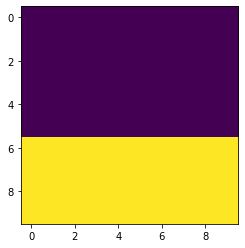

In [9]:
plt.imshow(get_dales_mask(10, 10, .6))

In [43]:
# noinspection PyProtectedMember

def get_dales_mask(nb_inputs, nb_out, ie_ratio) : 

    d_mask = torch.ones(nb_inputs, nb_out)
    #inhib_units = np.random.choice(nb_inputs, int(nb_inputs*ie_ratio), replace=False)
    inhib_units = torch.arange(ie_ratio*nb_inputs, dtype=int)
    #print(self.inhib_units)
    d_mask[inhib_units, :] = -1
    return d_mask

def init_weight_matrices(ie_ratio = 0.1):
    """Weights and uniform weight initialisation"""

    # Input to hidden layer
    w1 = nn.Parameter(torch.empty((INPUT_SIZE, NUM_HIDDEN), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(w1)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(w1, -bound, bound)

    # Hidden layer to output
    w2 = nn.Parameter(torch.empty((NUM_HIDDEN, NUM_CLASSES), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(w2)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(w2, -bound, bound)

    #Get fixed signs for the weight, 90% excitatory 
    signs = [get_dales_mask(*w.shape, ie_ratio).to(w.device) for w in (w1, w2)]

    return w1, w2, signs


def get_signed_weights(w, sign):
    """Get the signed value of the weight"""
    # Note abs is in principle not differentiable.
    # In practice, pytorch will set the derivative to 0 when the values are 0.
    # (see https://discuss.pytorch.org/t/how-does-autograd-deal-with-non-differentiable-opponents-such-as-abs-and-max/34538)
    # This has the adverse effect that, during training, if a synapse reaches 0,
    # it is "culled" and can not be recovered.
    # It should be possible to cheat here and either "wiggle" 0-valued synapses,
    # or to override abs gradient to return a very small random number.

    #TODO try ReLu or other activation
    #TODO reproduce paper https://www.biorxiv.org/content/10.1101/2020.11.02.364968v2.full

   # return torch.max(w, 0)*sign
    return torch.abs(w)*sign

def layer1(input_spikes, w1, tau, sign1):

    w1 = get_signed_weights(w1, sign1)

    batch_size = input_spikes.shape[0]

    # First layer: input to hidden
    v = torch.zeros((batch_size, NUM_HIDDEN), device=device, dtype=dtype)
    s = torch.zeros((batch_size, NUM_HIDDEN), device=device, dtype=dtype)
    s_rec = [s]
    h = torch.einsum("abc,cd->abd", (input_spikes, w1))
    alpha = np.exp(-DT / tau)
    
    for t in range(DURATION_STEPS - 1):
        new_v = (alpha*v + h[:, t, :])*(1-s) # multiply by 0 after a spike
        s = spike_fn(v-1) # threshold of 1
        v = new_v
        s_rec.append(s)
    s_rec = torch.stack(s_rec, dim=1)
    
    return s_rec

def layer2(s_rec, w2, tau, sign2):
    """Second layer: hidden to output"""
    w2 = get_signed_weights(w2, sign2)

    v_rec = membrane_only(s_rec, w2, tau=tau)
    return v_rec


def snn(input_spikes, w1, w2, signs, tau=5 * MS):
    """Run the simulation"""
        
    s_rec = layer1(input_spikes, w1, tau, signs[0])
    v_rec = layer2(s_rec, w2, tau, signs[1])

    # Return recorded membrane potential of output
    return v_rec

In [48]:
def train(w1, w2, signs, ipds, spikes, ipds_validation, spikes_validation, lr=0.01, n_epochs=30):
    """
    :param lr: learning rate
    :return:
    """

    ####################### MISSING CODE BELOW ########################
    # You need to learn parameters for two matrices
    # Optimiser and loss function
    optimizer = torch.optim.Adam([w1, w2], lr=lr)
    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()

    #print(f"Want loss for epoch 1 to be about {-np.log(1 / NUM_CLASSES):.2f}, multiply m by constant to get this")

    loss_hist = []
    val_loss_hist = []

    best_loss = 1e10
    val_loss_best_loss = 1e10

    for e in pbar(range(n_epochs)):
        local_loss = []
        for x_local, y_local in data_generator(discretise(ipds), spikes):
            # Run network
            output = snn(x_local, w1, w2, signs)
            # Compute cross entropy loss
            m = torch.sum(output, 1)*0.01  # Sum time dimension

            #reg = torch.abs(torch.clamp(torch.min(W1), -np.inf, 0)) * 100
            reg = 0

            loss = loss_fn(log_softmax_fn(m), y_local) + reg
            local_loss.append(loss.item())

            # Update gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_hist.append(np.mean(local_loss))

        val_local_loss = []
        for x_local, y_local in data_generator(discretise(ipds_validation), spikes_validation):
            # Run network
            output = snn(x_local, w1, w2, signs)
            # Compute cross entropy loss
            m = torch.sum(output, 1)*0.01  # Sum time dimension

            val_loss = loss_fn(log_softmax_fn(m), y_local) 
            val_local_loss.append(val_loss.item())

        val_loss_hist.append(np.mean(val_local_loss))

        if np.mean(val_local_loss) < val_loss_best_loss:
            val_loss_best_loss = np.mean(val_local_loss)
            best_weights = get_signed_weights(w1, signs[0]), get_signed_weights(w2, signs[1]), signs


        # noinspection PyStringFormat
       # #print("Epoch %i: loss=%.5f"%(e+1, np.mean(local_loss)))
        #print("Epoch %i: val_loss=%.5f"%(e+1, np.mean(val_local_loss)))

        #Early Stopping : 
        if torch.tensor(val_loss_hist[-10:]).argmin() == 0  and e>10: 
          print('Early Stop !')
          return best_weights

    # Plot the loss function over time
    plt.plot(loss_hist)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.tight_layout()

    plt.plot(val_loss_hist)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.tight_layout()

    return get_signed_weights(w1, signs[0]), get_signed_weights(w2, signs[1]), signs


In [ ]:
# Generate the training data
w1, w2, signs = init_weight_matrices(ie_ratio=1)

ipds_training, spikes_training = random_ipd_input_signal(num_samples)
ipds_validation, spikes_validation = random_ipd_input_signal(num_samples)

w1_trained, w2_trained, signs = train(w1, w2, signs, ipds_training, spikes_training, ipds_validation, spikes_validation)
#test test 


In [15]:
assert torch.max(w1_trained[signs[0] == -1]) < 0
assert torch.max(w2_trained[signs[1] == -1]) < 0

Chance accuracy level: 8.3%

Train classifier accuracy: 76.0%
Train absolute error: 5.6 deg

Test classifier accuracy: 67.5%
Test absolute error: 6.3 deg


67.48046875

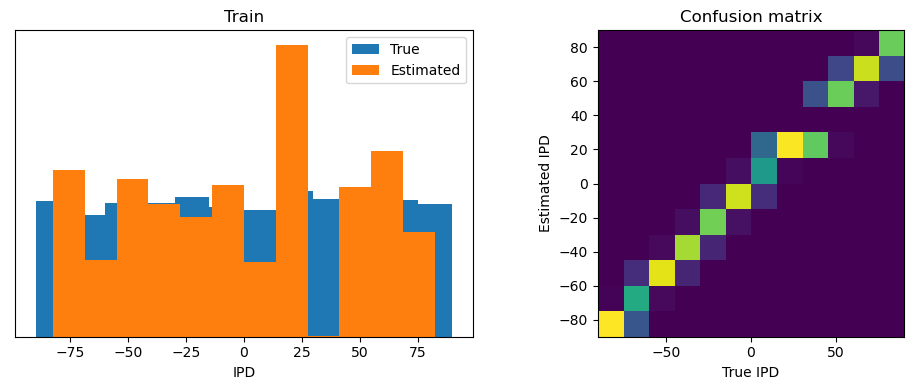

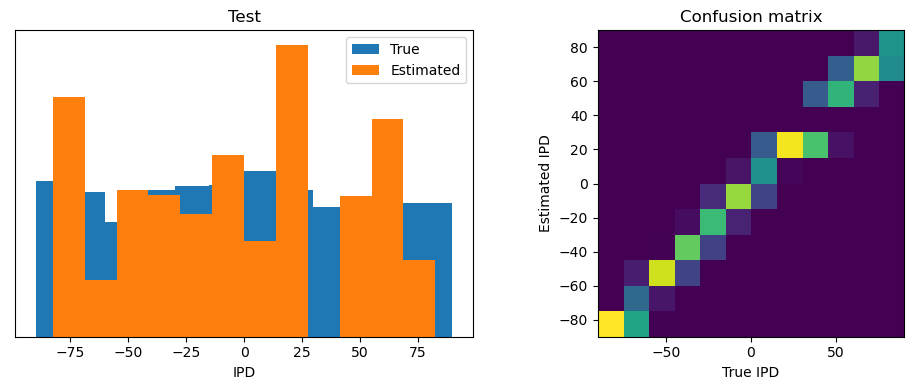

In [27]:
# Analyse
print(f"Chance accuracy level: {100 * 1 / NUM_CLASSES:.1f}%")
run_func = lambda x: snn(x, w1_trained, w2_trained, signs)
analyse_accuracy(ipds_training, spikes_training, run_func, 'Train')

ipds_test, spikes_test = random_ipd_input_signal(batch_size*n_testing_batches)
analyse_accuracy(ipds_test, spikes_test, run_func, 'Test')

In [ ]:
# Generate the training data
ipds_training, spikes_training = random_ipd_input_signal(num_samples)
ipds_validation, spikes_validation = random_ipd_input_signal(num_samples)

train_losses = []
test_losses = []

n_tests = 5

for i in pbar(range(11)):
    train_losses.append([])
    test_losses.append([])
    for test in range(n_tests) : 

        w1, w2, signs = init_weight_matrices(ie_ratio = i*0.1)
        w1_trained, w2_trained, signs = train(w1, w2, signs, ipds_training, spikes_training, ipds_validation, spikes_validation)

        run_func = lambda x: snn(x, w1_trained, w2_trained, signs)
        train_loss = analyse_accuracy(ipds_training, spikes_training, run_func, 'Train')

        ipds_test, spikes_test = random_ipd_input_signal(batch_size*n_testing_batches)
        test_loss = analyse_accuracy(ipds_test, spikes_test, run_func, 'Test')

        train_losses[-1].append(train_loss)
        test_losses[-1].append(test_loss)

train_losses, test_losses = np.array(train_losses), np.array(test_losses)

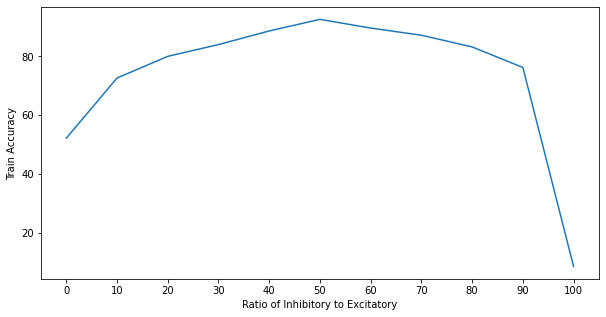

In [57]:
plt.figure(figsize=(10, 5))
plt.plot(10*np.arange(11), train_losses.mean(-1))
plt.xlabel('Ratio of Inhibitory to Excitatory')
plt.xticks(10*np.arange(11))
plt.ylabel('Train Accuracy')
plt.show()

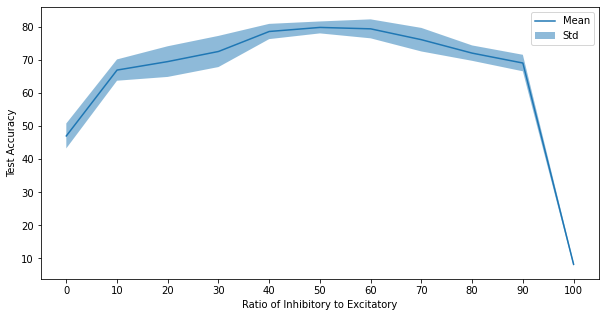

In [61]:
plt.figure(figsize=(10, 5))
plt.plot(10*np.arange(11), test_losses.mean(-1), label='Mean')
plt.fill_between(10*np.arange(11), test_losses.mean(-1) - test_losses.std(-1), test_losses.mean(-1) + test_losses.std(-1), alpha=.5, label='Std')
plt.xlabel('Ratio of Inhibitory to Excitatory')
plt.xticks(10*np.arange(11))
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

### Seems like 40-60 ratio is best !

## Future work
- Run multiple times/train longer
- Initialization and updates according to literature
- Try different activation functions
- Train the sign matrix
- Compare the weight matrices for each case
- Analyze the the spikes in the layers
- Stochastic/baseline firing

In [ ]:
def plot_single_weight_mat(ax, w):
    vmax = np.max(np.abs(w))
    im = ax.imshow(w, interpolation='nearest', aspect='auto', origin='lower', vmin=-vmax, vmax=vmax, cmap='seismic')
    ax.set_ylabel('Input neuron index')
    ax.set_xlabel('Hidden layer neuron index')
    ax.figure.colorbar(im, label="Weight", ax=ax)


def plot_weight_mats(w1, w2):
    plt.figure(figsize=(10, 4), dpi=100)
    ax = plt.subplot(121)
    plot_single_weight_mat(ax, w1.detach().cpu().numpy())

    ax = plt.subplot(122)
    plot_single_weight_mat(ax, w2.detach().cpu().numpy())

    plt.tight_layout()
    

plot_weight_mats(w1_trained, w2_trained)

: 

In [ ]:
(w2_trained < 0).float().mean()

: 

In [ ]:
def init_weight_matrices():
    """Weights and uniform weight initialisation"""

    # Input to hidden layer
    w1 = nn.Parameter(torch.empty((INPUT_SIZE, NUM_HIDDEN), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(w1)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(w1, -bound, bound)

    # Hidden layer to output
    w2 = nn.Parameter(torch.empty((NUM_HIDDEN, NUM_CLASSES), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(w2)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(w2, -bound, bound)

    #Get fixed signs for the weight, 90% excitatory 
    signs = [(torch.rand_like(w) > 0.1).float() for w in (w1, w2)]
    
    for s in signs : 
      s[s == 0] = -1
      s.requires_grad=False

    return w1, w2, signs


: 

In [ ]:
def train(ipds, spikes, ipds_validation, spikes_validation, lr=0.01):
    """
    :param lr: learning rate
    :return:
    """
    # Initialise a weight matrices
    w1, w2, signs = init_weight_matrices()

    ####################### MISSING CODE BELOW ########################
    # You need to learn parameters for two matrices
    # Optimiser and loss function
    optimizer = torch.optim.Adam([w1, w2], lr=lr)
    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()

    print(f"Want loss for epoch 1 to be about {-np.log(1 / NUM_CLASSES):.2f}, multiply m by constant to get this")

    loss_hist = []
    val_loss_hist = []

    best_loss = 1e10
    val_loss_best_loss = 1e10

    for e in pbar(range(N_EPOCHS)):
        local_loss = []
        for x_local, y_local in data_generator(discretise(ipds), spikes):
            # Run network
            output = snn(x_local, w1, w2, signs)
            # Compute cross entropy loss
            m = torch.sum(output, 1)*0.01  # Sum time dimension

            #reg = torch.abs(torch.clamp(torch.min(W1), -np.inf, 0)) * 100
            reg = 0

            loss = loss_fn(log_softmax_fn(m), y_local) + reg
            local_loss.append(loss.item())

            # Update gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_hist.append(np.mean(local_loss))

        val_local_loss = []
        for x_local, y_local in data_generator(discretise(ipds_validation), spikes_validation):
            # Run network
            output = snn(x_local, w1, w2, signs)
            # Compute cross entropy loss
            m = torch.sum(output, 1)*0.01  # Sum time dimension

            val_loss = loss_fn(log_softmax_fn(m), y_local) 
            val_local_loss.append(val_loss.item())

        val_loss_hist.append(np.mean(val_local_loss))

        if np.mean(val_local_loss) < val_loss_best_loss:
            val_loss_best_loss = np.mean(val_local_loss)
            best_weights = get_signed_weights(w1, signs[0]), get_signed_weights(w2, signs[1]), signs


        # noinspection PyStringFormat
        print("Epoch %i: loss=%.5f"%(e+1, np.mean(local_loss)))
        print("Epoch %i: val_loss=%.5f"%(e+1, np.mean(val_local_loss)))

        #Early Stopping : 
        if torch.tensor(val_loss_hist[-5:]).argmin() == 0  and e>5: 
          print('Early Stop !')
          return best_weights

    # Plot the loss function over time
    plt.plot(loss_hist)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.tight_layout()

    plt.plot(val_loss_hist)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.tight_layout()

    return get_signed_weights(w1, signs[0]), get_signed_weights(w2, signs[1]), signs

# Generate the training data
ipds_training, spikes_training = random_ipd_input_signal(num_samples)
ipds_validation, spikes_validation = random_ipd_input_signal(num_samples)


w1_trained, w2_trained, signs = train(ipds_training, spikes_training, ipds_validation, spikes_validation)



: 

In [ ]:
# Analyse
print(f"Chance accuracy level: {100 * 1 / NUM_CLASSES:.1f}%")
run_func = lambda x: snn(x, w1_trained, w2_trained, signs)
analyse_accuracy(ipds_training, spikes_training, run_func, 'Train')

ipds_test, spikes_test = random_ipd_input_signal(batch_size*n_testing_batches)
analyse_accuracy(ipds_test, spikes_test, run_func, 'Test')

: 

In [ ]:
def plot_weight_mats_sorted(w1, w2):
    w1 = w1.detach().cpu().numpy()
    w2 = w2.detach().cpu().numpy()

    # for each column of w1, compute the weighted mean and re-order according to that
    #A = np.arange(w1.shape[0])[:, None]
    A = np.hstack([np.arange(ANF_PER_EAR), -np.arange(ANF_PER_EAR)])[:, None]
    weighted_mean = np.mean((A*w1), axis=0)
    weighted_mean[np.max(w1, axis=0)<.5] = np.inf
    I = np.argsort(weighted_mean)
    w1 = w1[:, I]
    w2 = w2[I, :]

    # Plot the re-ordered weight matrices
    plt.figure(figsize=(10, 3), dpi=100)
    ax = plt.subplot(131)
    plot_single_weight_mat(ax, w1)
    ax.set_ylabel('Input neuron index')
    ax.set_xlabel('Hidden layer neuron index')
    ax.set_title('$W_1$')

    ax = plt.subplot(132)
    plot_single_weight_mat(ax, w2)
    ax.set_ylabel('Hidden layer neuron index')
    ax.set_xlabel('Output neuron index')
    ax.set_title('$W_2$')

    ax = plt.subplot(133)
    plot_single_weight_mat(ax, w1@w2)
    ax.set_ylabel('Input neuron index')
    ax.set_xlabel('Output neuron index')
    ax.set_title('$W_1W_2$')

    plt.tight_layout()

    # Plot some sample weights for hidden neurons

    big_weights = np.max(np.abs(w1), axis=0) > .5

    to_show_count = 15

    best_idcs = np.argsort(big_weights)[::-1][:to_show_count]


    fig, axs = plt.subplots(ncols=5, nrows=to_show_count // 5, dpi=150, sharex='all', sharey='all', constrained_layout=True)

    phi = np.linspace(-np.pi/2, np.pi/2, w1.shape[0]//2)

    for i, j in enumerate(best_idcs):

        ax = axs.ravel()[i]

        ax.plot(phi*180/np.pi, w1[:w1.shape[0]//2, j], label="Left ear")

        ax.plot(phi*180/np.pi, w1[w1.shape[0]//2:, j], label="Right ear")

    plt.suptitle("Individual $W_1$ weights")
    plt.legend(loc='best')
    plt.xlabel('Phase delay (deg)')

plot_weight_mats_sorted(w1_trained, w2_trained)

: 

Note a diagonal trend in W1 as well single contiguous bumps in columns of W2, suggesting a preference for coincidence detection.  However the accuracy gets much worse (50% on test).

In [ ]:
def plot_traces(ax, traces):
    cmap = matplotlib.cm.get_cmap('hsv')
    norm = matplotlib.colors.Normalize(vmin=-180, vmax=+180)

    c = continuise(np.arange(traces.shape[0])) * 180/np.pi
    totals = np.sum(traces, axis=1)
    z_sorting = np.argsort(totals)[::1]
    

    for j in z_sorting:
        trace = traces[j]
        color = cmap(norm(c[j]))
        ax.plot(trace, color=color)
    
    sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array(c)
    ax.figure.colorbar(sm, ax=ax, label='ipd')


def plot_single_run(angle, example_input, s_rec, v_rec):
    f, axs = plt.subplots(nrows=4, sharex='all', figsize=(4, 4), dpi=150, constrained_layout=True)
    
    f.suptitle(f'true angle: {angle*180/np.pi}')

    ax = axs[0]
    ax.imshow(example_input.T, aspect='auto', interpolation='nearest', origin='lower', cmap=plt.cm.gray_r)
    ax.set(
        ylabel='uV',
        title='spikes input neurons',
    )

    ax = axs[1]
    ax.imshow(s_rec.T, aspect='auto', interpolation='nearest', origin='lower', cmap=plt.cm.gray_r)
    ax.set(
        ylabel='uV',
        title='spikes hidden neurons',
    )

    ax = axs[2]
    plot_traces(ax, v_rec.T)
    ax.set(
        ylabel='uV',
        title='mem. output neurons',
    )

    ax = axs[3]
    plot_traces(ax, np.cumsum(v_rec.T, axis=1))
    ax.set(
        xlabel='time',
        ylabel='uV',
        title='cum. mem. output neurons',
    )

def study_single_example(angle, w1, w2):
    example_input = spikes_from_fixed_idp_input_signal(np.array([angle]))

    tau = 2 * MS

    s_rec = layer1(example_input, w1, tau, signs[0])
    v_rec = layer2(s_rec, w2, tau)

    example_input = example_input[0]
    s_rec = s_rec.detach().numpy()[0]
    v_rec = v_rec.detach().numpy()[0]

    plot_single_run(angle, example_input, s_rec, v_rec)
    


study_single_example(np.pi * 0.5, w1_trained, w2_trained)

: 

Looking a bit at membrane traces of the output neurions, it seems like the decision is taken mostly in the trough of the sinusoid input, probably because in that period the FRs are low enough that coincidence is more significative for the discrimination.


## Further work
- Fix gradient of ABS at 0.
- Reduce firing rates of AFN. What are realistic values?
- Check out Blake Richards' work showing that you can train ANNs following Dale's law without loss of performance.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8c8e89f8-1633-4423-bd6a-baf7e83aa31b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>